In [1]:
#### Loss of Y analysis in TCGA tumors using RNA-seq/gene expression
# 4-22-2022
# Esther Rheinbay

import sys, re
import pandas as pd
import numpy as np
import random
from scipy.stats import ttest_ind, spearmanr, norm, ks_2samp, mannwhitneyu, fisher_exact, pearsonr
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
from collections import Counter

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


In [2]:
workdir = '.'
fig_dir =  'Plots_Figures/'

In [3]:
# color palettes
TN_palette = {'N': 'lightblue', 'T': 'navy', 'F_N': 'mistyrose', 'F_T':'deeppink'}
Y_palette = {'fLOY': 'crimson', 'wt':'grey'}
palette = {'wt_male':'lightgrey', 'fLOY':'cornflowerblue', 'wt_female':'lightgrey', 'LOX':'deeppink'}

<h3> Load TCGA sample data and gene expression </h3>

In [4]:
# General sample info from https://gdc.cancer.gov/about-data/publications/pancanatlas
TCGA_sample_info = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=0,  header=0, index_col=1)
males = TCGA_sample_info[TCGA_sample_info.gender=='MALE'].index.values
females = TCGA_sample_info[TCGA_sample_info.gender=='FEMALE'].index.values
TCGA_survival = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name="ExtraEndpoints", index_col=1)

# TCGA sample type codes from https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
TCGA_sample_type_codes = {'01': 'TP', '02':'TR', '03':'TB', '04':'TRBM', '05':'TAP', '06':'TM', '07':'TAM', '08':'THOC', '09':'TBM', '10':'NB', '11':'NT', '12':'NBC', '13':'NEBV', '14':'NBM', '15':'15SH', '16':'16SH', '20':'CELLC', '40':'TRB', '50':'CELL', '60':'XP', '61':'XCL', '99':'99SH'}




In [5]:
# TCGA pancan expression data
# gene expression from pancan atlas (https://gdc.cancer.gov/about-data/publications/pancanatlas)
TCGA_pancan_exp = pd.read_csv('EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep='\t', header=0, index_col=0)

# sample codes from code table https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
tumor_codes = ['01', '02', '03', '04', '04', '06', '07', '08', '09']
normal_codes = ['10', '11', '12', '13', '14']


# divide samples into tumors and normals (-01*- are tumor samples; -06A- is a metastatic sample); most normals have code -11A-
stype = ['tumor' if x.split('-')[3][0:2] in tumor_codes else 'normal' if x.split('-')[3][0:2] in normal_codes else 'NA' for x in TCGA_pancan_exp.columns.values]

#stype = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x or '-06A-' in x) else 'normal' for x in TCGA_pancan_exp.columns.values]
sample_type = pd.Series(stype, index = TCGA_pancan_exp.columns.values)

#change index to gene names only
TCGA_pancan_exp.index = map(lambda x: x.split('|')[0], TCGA_pancan_exp.index.values)

# extract tumors only
tumor_exp = TCGA_pancan_exp[sample_type[sample_type=='tumor'].index.values]

# extract normal samples only
normal_exp = TCGA_pancan_exp[sample_type[sample_type=='normal'].index.values]

# shorten column names/patient IDs
tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
normal_exp.rename(columns = lambda x: x[0:12], inplace=True)

# remove duplicate gene expression data for the same sample
tumor_exp_unique = tumor_exp.iloc[:, ~tumor_exp.columns.duplicated()]
normal_exp_unique = normal_exp.iloc[:, ~normal_exp.columns.duplicated()]


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_52264/2632293095.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_52264/2632293095.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_exp.rename(columns = lambda x: x[0:12], inplace=True)


In [6]:
# split expression into males and females
common_males = list(set(tumor_exp_unique.columns.values).intersection(set(males)))
common_females = list(set(tumor_exp_unique.columns.values).intersection(set(females)))

tumor_exp_unique_males = tumor_exp_unique[common_males]
tumor_exp_unique_females = tumor_exp_unique[common_females]

normal_male_exp = normal_exp_unique[[x for x in normal_exp_unique.columns.values if x in TCGA_sample_info[TCGA_sample_info.gender=='MALE'].index.values]]
normal_female_exp = normal_exp_unique[[x for x in normal_exp_unique.columns.values if x in TCGA_sample_info[TCGA_sample_info.gender=='FEMALE'].index.values]]


In [7]:
# chrY genes, no PARs
chrY_genes =pd.read_csv('chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
chrY_genes_in_set = [ x for x in chrY_genes if x in tumor_exp.index.values]

/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_52264/224131165.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  chrY_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)


In [8]:
# subset expressioin data to chrY genes
tumor_exp_Y_males = tumor_exp_unique_males.loc[chrY_genes_in_set]
tumor_exp_Y_females = tumor_exp_unique_females.loc[chrY_genes_in_set]
normal_exp_Y_females = normal_female_exp.loc[chrY_genes_in_set]
normal_exp_Y_males = normal_male_exp.loc[chrY_genes_in_set]


<h3> Distribution of chrY gene expression in male normal and tumor samples </h3>

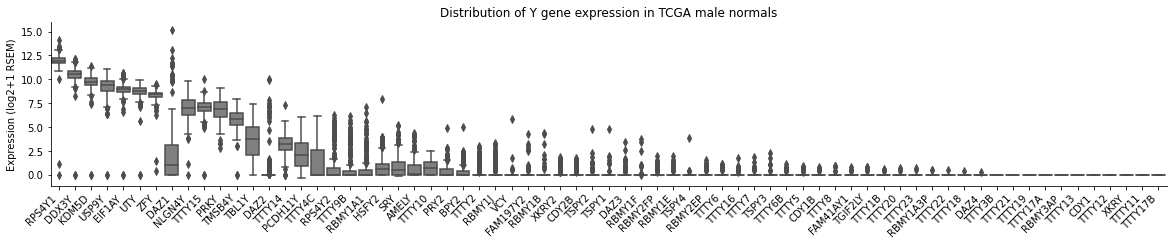

In [9]:
# Supplementary Figure 1A
# Plot distribution of Y gene expression across male normal samples 
normal_order = normal_exp_Y_males.apply(lambda x: np.mean(x), axis=1).sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
sns.boxplot(data = np.log2(normal_exp_Y_males.loc[normal_order.index] +1).transpose(), color = 'grey')
ax.set_ylabel('Expression (log2+1 RSEM)') 
plt.xticks(range(len(normal_order.index.values)), normal_order.index.values, rotation='45', ha='right');
ax.set_title('Distribution of Y gene expression in TCGA male normals');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir + 'LOY_wt_chrY_expression_boxplot_TCGA_normals.pdf')


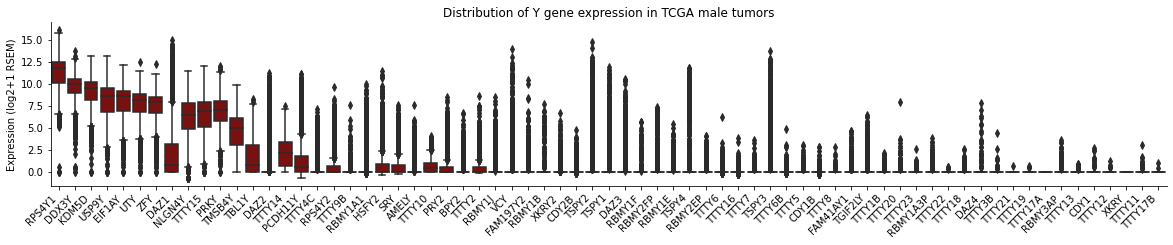

In [10]:
# Supplementary Figure 1B
# Plot distribution of Y gene expression across male tumor samples, but normal order (same order as above)
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
sns.boxplot(data = np.log2(tumor_exp_Y_males.loc[normal_order.index] +1).transpose(), color = 'darkred')
ax.set_ylabel('Expression (log2+1 RSEM)') 
plt.xticks(range(len(normal_order.index.values)), normal_order.index.values, rotation='45', ha='right');
ax.set_title('Distribution of Y gene expression in TCGA male tumors');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir + 'LOY_wt_chrY_expression_boxplot_TCGA_tumors.pdf')

<h3> 7 most highly expressed Y genes as "signature" </h3>

In [11]:
# 7-gene signature to measure Y expression
expressed_Y_genes = normal_order[np.log2(normal_order+1)>8].index.values
males_avg_Y_exp = tumor_exp_Y_males.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)

# normal male samples
males_avg_Y_exp_normal = normal_exp_Y_males.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)

# female controls
females_avg_Y_exp = tumor_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)
females_avg_Y_exp_normal = normal_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_52264/2682473882.py:3: RuntimeWarning: Mean of empty slice
  males_avg_Y_exp = tumor_exp_Y_males.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_52264/2682473882.py:9: RuntimeWarning: Mean of empty slice
  females_avg_Y_exp = tumor_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_52264/2682473882.py:10: RuntimeWarning: Mean of empty slice
  females_avg_Y_exp_normal = normal_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)


In [12]:
# chrY expression by tumor type with male samples, attach to big sample table
# confirmed that the values are the same as in males_avg_Y_exp, females_avg_Y_exp
import warnings
warnings.filterwarnings('ignore')
TCGA_sample_info['avgYexp_tumor'] = TCGA_sample_info.apply(lambda x: np.nanmean(tumor_exp_unique.loc[expressed_Y_genes][x.name]) if x.name in tumor_exp_unique.columns.values else np.nan, axis=1)


In [13]:
# list of housekeeping genes to normalize Y expression to total expression (does not contain Y genes)
# Source: Tirosh et al, Science, 2016 (https://www.science.org/doi/10.1126/science.aad0501)
housekeeping = pd.read_csv(workdir + 'tirosh_house_keeping.txt', sep='\t', header=None, skiprows=2)
housekeeping.columns = ['gene']

# replace HPRT with HPRT1, its human gene name
housekeeping[housekeeping.gene=='HPRT']='HPRT1'

# calculate housekeeping averages and ratio
TCGA_sample_info['avg_housekeeping_tumor'] = TCGA_sample_info.apply(lambda x: np.nanmean(tumor_exp_unique.loc[housekeeping.gene][x.name]) if x.name in tumor_exp_unique.columns.values else np.nan, axis=1)
TCGA_sample_info['ratio_Y_housekeeping_tumor']= TCGA_sample_info.apply(lambda x: x.avgYexp_tumor/x.avg_housekeeping_tumor, axis=1)

In [14]:
# same values for normals
TCGA_sample_info['avgYexp_normal'] = TCGA_sample_info.apply(lambda x: np.nanmean(normal_exp_unique.loc[expressed_Y_genes][x.name]) if x.name in normal_exp_unique.columns.values else np.nan, axis=1)
TCGA_sample_info['avg_housekeeping_normal'] = TCGA_sample_info.apply(lambda x: np.nanmean(normal_exp_unique.loc[housekeeping.gene][x.name]) if x.name in normal_exp_unique.columns.values else np.nan, axis=1)
TCGA_sample_info['ratio_Y_housekeeping_normal']= TCGA_sample_info.apply(lambda x: x.avgYexp_normal/x.avg_housekeeping_normal, axis=1)

<h3> Distribution of Y gene expression in male and female normal and tumor samples </h3>

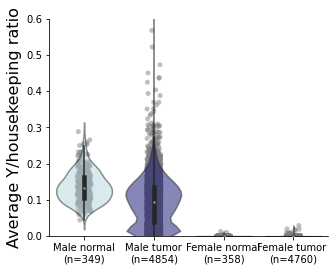

In [15]:
# All TCGA samples, remove samples with discordant sex annotation from WEX calling 
# version with females included as control for RNA cross-mapping
#discordant = pd.read_excel(workdir + 'TCGA_sex_misclassified.xlsx', sheet_name=0,  header=0, index_col=0)

male_CNV_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_1',  header=0, index_col=0)
female_CNV_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_2',  header=0, index_col=0)
discordant = male_CNV_calls[male_CNV_calls.Flag=='sex_discordant_or_ambiguous_copy_number_sex_chromsome'].append(female_CNV_calls[female_CNV_calls.Flag=='sex_discordant_or_ambiguous_copy_number_sex_chromsome'])

#chrY to housekeeping ratio
t_ratio_males = TCGA_sample_info.loc[[x for x in males if not x in discordant.index.values]].ratio_Y_housekeeping_tumor
n_ratio_males = TCGA_sample_info.loc[[x for x in males if not x in discordant.index.values]].ratio_Y_housekeeping_normal
t_ratio_females = TCGA_sample_info.loc[[x for x in females if not x in discordant.index.values]].ratio_Y_housekeeping_tumor
n_ratio_females = TCGA_sample_info.loc[[x for x in females if not x in discordant.index.values]].ratio_Y_housekeeping_normal


df = pd.DataFrame(pd.concat([n_ratio_males,  t_ratio_males, n_ratio_females,t_ratio_females]))
df.columns = ['ratio_Y_housekeeping']
df['type'] = ['N']*len(n_ratio_males)+['T']*len(t_ratio_males) + ['F_N']*len(n_ratio_females) + ['F_T']*len(t_ratio_females)

# Supplementary Figure 1C
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.violinplot(x = 'type', y = 'ratio_Y_housekeeping', data=df, orient='v',alpha=0.3, zorder=1, scale='width', palette=TN_palette)
sns.stripplot(x = 'type', y = 'ratio_Y_housekeeping', data=df, color ='grey', orient='v', alpha=0.2, zorder=0)
plt.setp(ax.collections, alpha=.5)
ax.set_ylabel('Average Y/housekeeping ratio', fontsize=16)
ax.set_ylim([0,0.6])
ax.set_xticklabels(['Male normal\n(n=' + str(len(n_ratio_males.dropna())) +')','Male tumor\n(n=' + str(len(t_ratio_males.dropna()))+')',  'Female normal\n(n=' + str(len(n_ratio_females.dropna())) +')','Female tumor \n(n=' + str(len(t_ratio_females.dropna()))+')'])

ax.set_xlabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir + 'Y_status_by_gender.pdf')

<h3> Classification of tumor samples into "functional" loss of Y (fLOY) and "wt" cases </h3>

In [16]:
# Classification into flOY and wt
TCGA_sample_info['Y_status'] = TCGA_sample_info.apply(lambda x: 'fLOY' if x.ratio_Y_housekeeping_tumor<0.035 else ('NaN' if np.isnan(x.ratio_Y_housekeeping_tumor) else 'wt'), axis=1)
TCGA_sample_info['sex_chromosome_status'] = TCGA_sample_info.apply(lambda x: x.Y_status if x.name in males  else 'NA', axis=1)
TCGA_sample_info.to_csv('TCGA_fLOY_status_igv.txt', sep='\t', header=True, index=True, columns = ['type','gender', 'avgYexp_tumor', 'avg_housekeeping_tumor', 'ratio_Y_housekeeping_tumor', 'Y_status'])

fLOY_samples = TCGA_sample_info[(TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.Y_status=='fLOY')].index.values
wt_samples = TCGA_sample_info[(TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.Y_status=='wt')].index.values

print(len(fLOY_samples)/(len(wt_samples)+len(fLOY_samples))*100, '% of male tumors have fLOY.')


23.628518594616807 % of male tumors have fLOY.


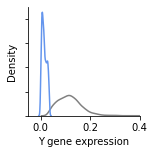

In [17]:
# density plot for cartoon in Figure 1A adn Supplementary Figure 1D
fig, ax = plt.subplots(1,1, figsize = (2,2))
sns.distplot(TCGA_sample_info[(TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.Y_status=='wt')].ratio_Y_housekeeping_tumor, hist=False, color ='grey')
sns.distplot(TCGA_sample_info[(TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.Y_status=='fLOY')].ratio_Y_housekeeping_tumor, hist=False, color ='cornflowerblue')
ax.set_yticklabels('')

ax.set_xlim(-0.05,0.4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Y gene expression')
ax.set_ylabel('Density')
plt.savefig(fig_dir + 'Y_ratio_distribution_by_fLOY.pdf')


<h3> Fraction of samples with fLOY by tumor type </h3>

In [18]:
# Male tumor types dataframe
tumor_types = pd.DataFrame(index = TCGA_sample_info[(TCGA_sample_info.gender=='MALE')].type.unique(), columns = ['fraction_fLOY'])
tumor_types['fraction_fLOY'] = tumor_types.apply(lambda x:TCGA_sample_info[(TCGA_sample_info.type == x.name) & (TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.Y_status=='fLOY')].shape[0]/TCGA_sample_info[(TCGA_sample_info.type == x.name) & (TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.Y_status!='NaN')].shape[0], axis=1)

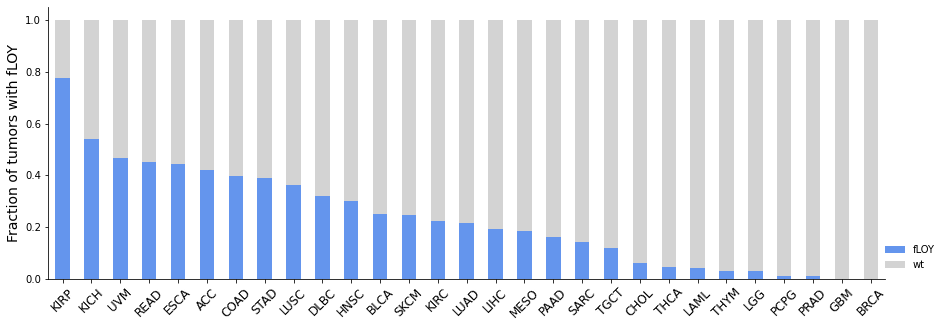

In [19]:
# Supplementary Figure 2C
df = TCGA_sample_info[TCGA_sample_info.sex_chromosome_status.isin(['wt', 'fLOY'])].groupby('type')['sex_chromosome_status'].value_counts()/TCGA_sample_info[TCGA_sample_info.sex_chromosome_status.isin(['wt', 'fLOY'])].groupby('type')['sex_chromosome_status'].count()
order = tumor_types.sort_values(by='fraction_fLOY', ascending=False).index
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

df.unstack().loc[order].plot.bar(stacked=True, ax=ax, color= {'wt':'lightgrey', 'fLOY':'cornflowerblue'})
ax.legend(bbox_to_anchor=(1.07, 0), frameon=False,  loc= 'lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction of tumors with fLOY', fontsize=14)
ax.set_xticklabels(tumor_types.sort_values(by='fraction_fLOY', ascending=False).index,rotation=45, fontsize=12);
ax.set_xlabel('');
plt.savefig(fig_dir+ 'Fraction_fLOY_tumor_types.pdf')

